# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal
### Projet A2024
----
Équipe T - TODO
### Objectif
Prédiction de **la consommation en carburant de voitures récentes**.

### Données
Le jeu de données contient pour presque 400 véhicule, la consommation moyenne en L/100km, l'année de frabrication, le type de véhicule, le nombre de cylindre, cylindree, la transmission et la boite.

- `train.csv` est l'ensemble d'entraînement
- `test.csv` est l'ensemble de test


## Chargement des données

Importation des librairies utilisées dans le calepin.

// TODO: à enlever à la fin:

Pour importer librairies:
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"], ...)

In [30]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, DecisionTree

In [31]:
function standardize(data)
    return (data .- mean(data)) ./ std(data)
end

function standardize_data(data)
    stddata = deepcopy(data)
   for col in names(stddata)
        if eltype(stddata[!, col]) <: Number
            stddata[!, col] = standardize(stddata[!, col])
        end
    end
    return stddata
end

standardize_data (generic function with 1 method)

In [32]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end

function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    return select!(encoded_data, Not([:type, :transmission, :boite, :cylindree, :nombre_cylindres]))
end

encode_data (generic function with 1 method)

In [33]:
function getStandardEncodedData(data)
    data_copy = deepcopy(data)
    standardised_data = standardize_data(data_copy)
    standardised_data = encode_data(standardised_data,)
    return standardised_data
end




getStandardEncodedData (generic function with 1 method)

In [34]:
function rmse(y, ychap)
    return sqrt(mean((ychap .- y).^2))
end


rmse (generic function with 1 method)

In [35]:
function rsquared(y, ychap)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- ychap).^2)
    return ss_res / ss_total
end


rsquared (generic function with 1 method)

In [36]:
function split_data(data,k)
    n = size(data, 1)
    validation_size = floor(Int, n * k)

    validation_indices = rand(1:n, validation_size)  
    
    validation_data = data[validation_indices, :]
    training_data = data[setdiff(1:n, validation_indices), :]
    
    return training_data, validation_data
end

split_data (generic function with 1 method)

In [37]:
function regression(standardised_data, trainTestSplitPercentage)
    training_data, test_data = split_data(standardised_data, trainTestSplitPercentage)
    X_train =  Matrix(training_data[:, Not(:consommation)])
    y_train = training_data[:, :consommation]

    X_test = Matrix(test_data[:, Not(:consommation)])
    y_test = test_data[:, :consommation]

    beta = X_train \ y_train

    ychap =  X_test * beta
    ychap = (ychap .* std(standardised_data[:, :consommation])) .+ mean(standardised_data[:, :consommation])
    y_test = (y_test .* std(standardised_data[:, :consommation])) .+ mean(standardised_data[:, :consommation])
    # print("regression\n")
    # print("r2 = ", rsquared(y_test, ychap), "\n")
    rmseval = rmse(y_test, ychap)
    # print("rmse = ", rmseval , "\n\n")
    return rmseval
end


regression (generic function with 1 method)

In [ ]:
function decisionTree(standardised_data, trainTestSplitPercentage, max_depth)
    training_data, test_data = split_data(standardised_data, trainTestSplitPercentage)
    X_train =  Matrix(training_data[:, Not(:consommation)])
    y_train = training_data[:, :consommation]

    X_test = Matrix(test_data[:, Not(:consommation)])
    y_test = test_data[:, :consommation]


    model = DecisionTreeRegressor(max_depth=max_depth)
    fit!(model, X_train, y_train)


    ychap =  predict(model, X_test)
    ychap = (ychap .* std(data[:, :consommation])) .+ mean(data[:, :consommation])
    y_test = (y_test .* std(data[:, :consommation])) .+ mean(data[:, :consommation])

    # print("regression\n")
    # print("r2 = ", rsquared(y_test, ychap), "\n")
    rmseval = rmse(y_test, ychap)
    # print("rmse = ", rmseval , "\n\n")
    return rmseval
end


decisionTree (generic function with 2 methods)

In [39]:
function ridge_regression(standardised_data, lambda, trainTestSplitPercentage)
    training_data, test_data = split_data(standardised_data, trainTestSplitPercentage)
    X_train =  Matrix(training_data[:, Not(:consommation)])
    y_train = training_data[:, :consommation]

    X_test = Matrix(test_data[:, Not(:consommation)])
    y_test = test_data[:, :consommation]


    beta = (X_train'X_train + lambda*I)\X_train'y_train

    ychap =  X_test * beta
    ychap = (ychap .* std(standardised_data[:, :consommation])) .+ mean(standardised_data[:, :consommation])
    y_test = (y_test .* std(standardised_data[:, :consommation])) .+ mean(standardised_data[:, :consommation])
    # print("ridge: \n")
    # print("r2 = ", rsquared(y_test, ychap), "\n")
    rmseval = rmse(y_test, ychap)
    # print("rmse = ", rmseval , "\n\n")
    return rmseval
end

ridge_regression (generic function with 1 method)

In [66]:
function lasso(X, y, lambda)
    n, p = size(X)
    beta = zeros(p)
    max_iter = 1000
    tol = 1e-4
    for i in 1:max_iter
        beta_old = deepcopy(beta)
        for j in 1:p
            beta[j] = 0
            r = y - X * beta
            z = X[:, j]' * r
            beta[j] = max(z - lambda/2, 0) - max(-z - lambda/2, 0)
            beta[j] /= sum(X[:, j].^2)
        end
        if norm(beta - beta_old) < tol
            break
        end
    end
    return beta
end


function lasso_regression(standardised_data, lambda, trainTestSplitPercentage)
    training_data, test_data = split_data(standardised_data, trainTestSplitPercentage)
    X_train =  Matrix(training_data[:, Not(:consommation)])
    y_train = training_data[:, :consommation]

    X_test = Matrix(test_data[:, Not(:consommation)])
    y_test = test_data[:, :consommation]

    beta = lasso(X_train, y_train, lambda)

    ychap =  X_test * beta
    ychap = (ychap .* std(standardised_data[:, :consommation])) .+ mean(standardised_data[:, :consommation])
    y_test = (y_test .* std(standardised_data[:, :consommation])) .+ mean(standardised_data[:, :consommation])
    # print("lasso: \n")
    # print("r2 = ", rsquared(y_test, ychap), "\n")
    rmseval = rmse(y_test, ychap)
    # print("rmse = ", rmseval , "\n\n")
    return rmseval
end

lasso_regression (generic function with 1 method)

In [40]:
trainData = CSV.read("./data/train.csv", DataFrame)
testData = CSV.read("./data/test.csv", DataFrame)
first(trainData, 1)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2023,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"


In [41]:
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => "."))


396-element Vector{Float64}:
 4.4
 2.0
 3.3
 5.0
 4.4
 4.4
 1.5
 1.5
 3.8
 3.3
 3.3
 5.0
 4.4
 ⋮
 2.0
 3.7
 3.8
 2.4
 3.5
 2.0
 2.0
 4.4
 3.3
 1.5
 3.3
 2.4

In [42]:
trainData[!,:volume_gaz] = trainData[!,:nombre_cylindres] .* trainData[!,:cylindree]
first(trainData, 1)


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,volume_gaz
,Int64,String31,Int64,Float64,String15,String15,Float64,Float64
1,2023,voiture_moyenne,8,4.4,integrale,automatique,13.8359,35.2


In [67]:
data = getStandardEncodedData(trainData)
n = 0
for i in range(0, 1, length=100)
    n += regression(data, 0.05)
end
print("average rmse for regression: ", n/100, "\n")

n = 0
for i in range(0, 1, length=100)
    n += decisionTree(data, 0.05, 5)
end
print("average rmse for decision Tree: ", n/100, "\n")

n = 0
for i in range(0, 1, length=100)
    n += ridge_regression(data, 10, 0.05)
end
print("average rmse for ridge: ", n/100, "\n")

n = 0
for i in range(0, 1, length=100)
    n += lasso_regression(data, 10, 0.05)
end
print("average rmse for lasso: ", n/100, "\n")


average rmse for regression: 0.4363298715466148
average rmse for decision Tree: 0.42182792809580894
average rmse for ridge: 0.4523567084643813
average rmse for lasso: NaN


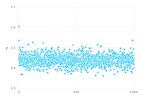

In [55]:
#search for the best lambda
rmses = []
for lambda in range(1, 1000, length=1000)
        m = 0
        for i in range(1, 10, length=10)
            m += decisionTree(data, 0.05, lambda)
        end
        push!(rmses, m/10)
end
plot(y=rmses)


In [70]:
for type in unique(trainData.type)
    println(type)
    data_type = trainData[trainData.type .== type, :]
    println(combine(groupby(data_type, :transmission), :consommation => mean, :volume_gaz => mean, nrow => :nrow))
    println()
end

voiture_moyenne
3×4 DataFrame
 Row │ transmission  consommation_mean  volume_gaz_mean  nrow  
     │ String15      Float64            Float64          Int64 
─────┼─────────────────────────────────────────────────────────
   1 │ integrale              10.7516          20.9773      22
   2 │ propulsion             11.2341          22.04         5
   3 │ traction                7.67265          9.59091     11

VUS_petit
3×4 DataFrame
 Row │ transmission  consommation_mean  volume_gaz_mean  nrow  
     │ String15      Float64            Float64          Int64 
─────┼─────────────────────────────────────────────────────────
   1 │ integrale              10.1752           11.202      50
   2 │ traction                9.45358          10.5959     49
   3 │ 4x4                     9.93476          12.2364     11

voiture_compacte
3×4 DataFrame
 Row │ transmission  consommation_mean  volume_gaz_mean  nrow  
     │ String15      Float64            Float64          Int64 
─────┼─────────────────

In [ ]:
for type in unique(trainData.type)
    println(type)
    data_type = trainData[trainData.type .== type, :]
    display(plot(x=data_type.volume_gaz, y=data_type.consommation))
    println()
end

## Exploration des données